In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, approx
from pyiga import assemble
from sksparse.cholmod import cholesky

from scipy.sparse.linalg import onenormest, splu, LinearOperator

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [82]:
deg=1
N=1

kvs=2*(bspline.make_knots(deg,0.0,1.0,N),)

n=2*bspline.numdofs(kvs)
#geo=geometry.quarter_annulus()
geo2=geometry.quarter_annulus()
geo=geometry.unit_square()
#geo2=geometry.unit_square().scale((0.5,1)).translate((0.5,0))

E = lambda x,y: (-1/pi*cos(2*pi*x)*sin(2*pi*y),1/pi*sin(2*pi*x)*cos(2*pi*y))
curl2DE = lambda x,y: 4*cos(2*pi*x)*cos(2*pi*y)
f = lambda x,y: (-(8*pi+1/pi)*cos(2*pi*x)*sin(2*pi*y), (8*pi+1/pi)*sin(2*pi*x)*cos(2*pi*y))
#vis.plot_quiver(E, geo=geo, res=30)
#plt.axis('scaled');

Nh=np.zeros(n)

Ah = assemble.assemble('curl2D(E) * curl2D(v) * dx', kvs=kvs, bfuns=[('E',2), ('v',2)], geo=geo)
Mh = assemble.assemble('inner(E,v) * dx', kvs=kvs, bfuns=[('E',2), ('v',2)], geo=geo)
Fh = assemble.assemble('inner(f,v) * dx', kvs=kvs, bfuns=[('v',2)], geo=geo, f=f).ravel()

# bcs=[]
# for b in [(0,0),(0,1),(1,0),(1,1)]:
#     bdofs=assemble.boundary_dofs(kvs,[b], ravel=True)
#     vals=approx.interpolate_tangential(kvs[0], f=lambda x,y: 0., geo=geo.boundary([b]), dim=2)
#     bcs.append()
#     dir_bcs=assemble.combine_bcs()

# dir_bcs=assemble.compute_dirichlet_bcs(kvs, geo, [('left', 0.), ('top', 0.),(),()])
    
#### Neumann
for b in [(0,0),(0,1),(1,0),(1,1)]:
    bdofs=assemble.boundary_dofs(kvs,[b], ravel=True)
    bdofs=np.concatenate([bdofs,bdofs+n//2])
    # print(bdofs)
    # print(assemble.assemble('g * (cross(v,n)) * ds', kvs=kvs, bfuns=[('v',2)], geo=geo, boundary=[b], g=curlE).ravel())
    Nh[bdofs] += assemble.assemble('gN * cross(n,v) * ds', kvs=kvs, bfuns=[('v',2)], geo=geo, boundary=[b], gN=curl2DE).ravel()
    
#print(Fh,Nh)

E_moments = assemble.assemble('inner(E,v) * dx', kvs=kvs, bfuns=[('v',2)], geo=geo, E=E).ravel()
E_ = cholesky(Mh.tocsc())(E_moments)
Eh_ = cholesky((Ah+Mh).tocsc())(Fh+Nh)

#print(E_.reshape(2,n//2).shape)
E_func = lambda x,y: (bspline.BSplineFunc(kvs=kvs,coeffs=E_[:n//2])(x,y),bspline.BSplineFunc(kvs=kvs,coeffs=E_[n//2:])(x,y))
Eh_func = lambda x,y: (bspline.BSplineFunc(kvs=kvs,coeffs=Eh_[:n//2])(x,y),bspline.BSplineFunc(kvs=kvs,coeffs=Eh_[n//2:])(x,y))


err = Eh_-E_
Ah_err = err@(Ah+Mh)@err 

print(Ah_err)
#vis.plot_quiver(Eh_func, geo=geo, res=30)

0.04517263130486292


In [83]:
n

8

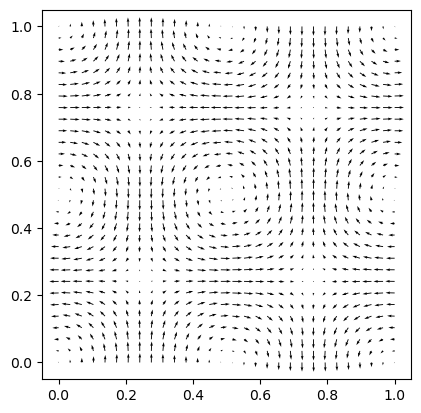

In [78]:
vis.plot_quiver(Eh_func, geo=geo, res=30)
plt.axis('scaled');

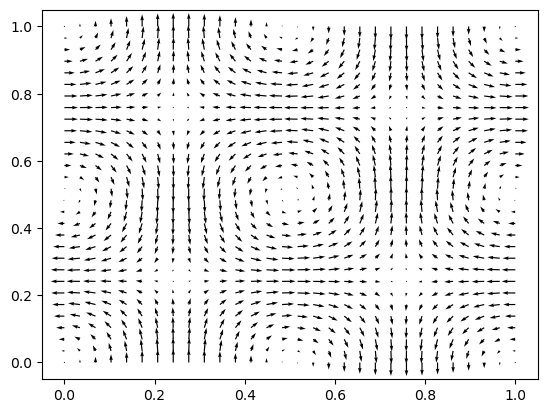

In [81]:
vis.plot_quiver(E, geo=geo, res=30)

In [9]:
g = kvs[0].greville()
No = geo.boundary([(1,0)]).grid_outer_normal((g,)).reshape(-1,2).T
C = bspline.collocation(kvs[0],g)

In [10]:
No

array([[ 1.     ,  0.99743,  0.97568,  0.92979,  0.85866,  0.76316,  0.64621,  0.51254,  0.36809,  0.21918,  0.07167,  0.     ],
       [-0.     ,  0.07167,  0.21918,  0.36809,  0.51254,  0.64621,  0.76316,  0.85866,  0.92979,  0.97568,  0.99743,  1.     ]])

In [11]:
C.A

array([[1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.25 , 0.625, 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.125, 0.75 , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.125, 0.75 , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.125, 0.75 , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.125, 0.75 , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.75 , 0.125, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.75 , 0.125, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.75 , 0.125, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.75 , 0.125, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,

In [12]:
N0=scipy.sparse.spdiags(No[0], 0, len(No[0]), len(No[0]))
N1=scipy.sparse.spdiags(No[1], 0, len(No[1]), len(No[1]))
print(N1@C-N0@C.A)

[[-1.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [-0.23144 -0.5786  -0.11572  0.       0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.      -0.09456 -0.56738 -0.09456  0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.      -0.07021 -0.42127 -0.07021  0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.      -0.04327 -0.2596  -0.04327  0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.      -0.01462 -0.08772 -0.01462  0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.01462  0.08772  0.01462  0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.04327  0.2596   0.04327  0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       0.07021  0.42127  0.07021  0.       0.     ]
 

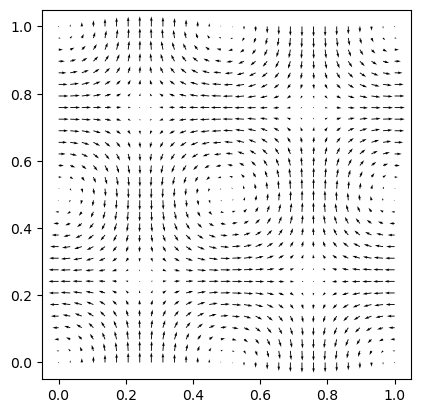

In [6]:
vis.plot_quiver(f, geo=geo, res=30)
plt.axis('scaled');